In [1]:
import os
os.environ['PYSPARK_PYTHON'] = '/home/luban/anaconda3/envs/python36/bin/python'
import findspark
findspark.init()

from pyspark import *
from pyspark.sql import *

app_name = 'xuyunqing_juypter'
conf = (SparkConf().setAppName(app_name)
        .set('spark.master', 'yarn')
        .set('spark.submit.deployMode', 'client')
        .set('spark.driver.memory',                  '20g')
        .set('spark.executor.memory',                '8g')
        .set('spark.dynamicAllocation.minExecutors', '2')
        .set('spark.dynamicAllocation.maxExecutors', '200')
        .set('spark.yarn.queue',                     'root.pricing_dape_core_service_prod')
        .set('spark.ui.port','8060')
        .set('spark.executor.memoryOverhead','4096')
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set('spark.driver.allowMultipleContexts', 'True')
        .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2')
        .set('spark.pyspark.driver.python',          '/home/luban/anaconda3/envs/python36/bin/python')
        .set('spark.pyspark.python', './python3.6.2/bin/python')
        .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
        )
spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
sc = spark.sparkContext

from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
hc = HiveContext(sc)

In [3]:
df = spark.sql('''
with t1 as (
    select
        distinct aaa.passenger_id,
        split(explore_discount_pair, ',') [0] as th_discount,
        split(explore_discount_pair, ',') [1] as pk_discount,
        one_discount,
        two_discount,
        fail_discount
    from(
            select
                distinct param ['explore_discount_pair'] as explore_discount_pair,
                param ['passenger_id'] as passenger_id
            from
                ppe.ods_log_ai_price
            where
                concat_ws('-', year, month, day) between '2023-03-31' and '2023-04-17'
                and nvl(param ['explore'], 0) in (1, 2)
                and param ['area_id'] in (12,19,27,29,37,41,48,50,51,62,79,80,81,83,84,87,90,92,93,94,95,97,100,101,106,108,110,111,112,113,114,115,121,123,134,136,139,142,143,147,151,152,155,159,161,165,167,170,172,173,176,182,186,188,189,221,223,227,233,235,240,241,244,245,250,257,263,279,285,289,304,307,319)
                and param ['group'] = 'rgroup_explore_tequ_fast_tehui_carpool_explore'
                and param ['explore_discount_pair'] != ''
        ) aaa
        left join(
            select
                distinct param ['passenger_id'] as passenger_id,
                param ['one_discount'] as one_discount,
                param ['two_discount'] as two_discount,
                param ['fail_discount'] as fail_discount
            from
                engine_ml.ods_log_g_passenger_price_result
            where
                concat_ws('-', year, month, day) between '2023-03-31' and '2023-04-17'
                and param ['city'] in (12,19,27,29,37,41,48,50,51,62,79,80,81,83,84,87,90,92,93,94,95,97,100,101,106,108,110,111,112,113,114,115,121,123,134,136,139,142,143,147,151,152,155,159,161,165,167,170,172,173,176,182,186,188,189,221,223,227,233,235,240,241,244,245,250,257,263,279,285,289,304,307,319)
                and param ['strategy_type'] = 'twoPriceExploreV0'
        ) bbb on aaa.passenger_id = bbb.passenger_id
)


select
    product_line,
    city_id,
    aa.passenger_id,
    th_discount,
    pk_discount,
    one_discount,
    two_discount,
    fail_discount,
    subsidy_hufan,
    gmv,
    dt
from
    (
        select
            product_line,
            city_id,
            passenger_id,
            subsidy_hufan,
            gmv,
            dt
        from
            mp_data.dwm_trip_trd_psg_core_di
        where
            dt between '2023-03-31'
            and '2023-04-17'
            and city_id in (12,19,27,29,37,41,48,50,51,62,79,80,81,83,84,87,90,92,93,94,95,97,100,101,106,108,110,111,112,113,114,115,121,123,134,136,139,142,143,147,151,152,155,159,161,165,167,170,172,173,176,182,186,188,189,221,223,227,233,235,240,241,244,245,250,257,263,279,285,289,304,307,319)
    ) aa
    inner join t1 on aa.passenger_id = t1.passenger_id
''').toPandas()
df

,product_line,city_id,passenger_id,th_discount,pk_discount,one_discount,two_discount,fail_discount,subsidy_hufan,gmv,dt
0,出租车,142,696705,60,100,0.59,0.74,0.97,0.000000,0.000000,2023-03-31
1,线上计价_普通出租车,257,696705,60,100,0.59,0.74,0.97,0.000000,0.000000,2023-04-07
2,普通出租车,142,696705,60,100,0.59,0.74,0.97,0.000000,0.000000,2023-03-31
3,普通快车非拼,142,696705,60,100,0.59,0.74,0.97,0.000000,0.000000,2023-03-31
4,泛快优,257,696705,60,100,0.59,0.74,0.97,0.000000,8.500000,2023-04-07
...,...,...,...,...,...,...,...,...,...,...,...
23604218,普通出租车,227,52776773955031,95,100,0.71,0.86,0.91,0.000000,0.000000,2023-04-16
23604219,拼车,227,52776773955031,95,100,0.71,0.86,0.91,0.000000,0.000000,2023-04-16
23604220,网约车,227,52776773955031,95,100,0.71,0.86,0.91,0.000000,0.000000,2023-04-16
23604221,普通快车含拼,227,52776773955031,95,100,0.71,0.86,0.91,0.000000,0.000000,2023-04-16


In [16]:
df = hc.sql('''
select
    city_id,
    case
        when one_discount >= 0.6
        and one_discount < 0.65 then 0.60
        when one_discount >= 0.65
        and one_discount < 0.70 then 0.65
        when one_discount >= 0.70
        and one_discount < 0.75 then 0.70
        when one_discount >= 0.75
        and one_discount < 0.80 then 0.75
        when one_discount >= 0.80
        and one_discount < 0.85 then 0.80
        when one_discount >= 0.85
        and one_discount < 0.90 then 0.85
        when one_discount >= 0.90
        and one_discount < 0.95 then 0.90
        when one_discount >= 0.95
        and one_discount < 1.00 then 0.95
    end as one_discount,
    count(passenger_id) as psg_num,
    sum(subsidy_hufan) as subsidy_hufan,
    sum(gmv) as gmv,
    sum(subsidy_hufan) / sum(gmv) as hufan_rate,
    sum(gmv) / count(passenger_id) as pp_gmv,
    dt
from
    smt_stg.budget_allocation_tequ_explore_202304
where
    product_line = '市内拼车'
group by
    city_id,
    case
        when one_discount >= 0.6
        and one_discount < 0.65 then 0.60
        when one_discount >= 0.65
        and one_discount < 0.70 then 0.65
        when one_discount >= 0.70
        and one_discount < 0.75 then 0.70
        when one_discount >= 0.75
        and one_discount < 0.80 then 0.75
        when one_discount >= 0.80
        and one_discount < 0.85 then 0.80
        when one_discount >= 0.85
        and one_discount < 0.90 then 0.85
        when one_discount >= 0.90
        and one_discount < 0.95 then 0.90
        when one_discount >= 0.95
        and one_discount < 1.00 then 0.95
    end,
    dt
''').toPandas()
df

,city_id,one_discount,psg_num,subsidy_hufan,gmv,hufan_rate,pp_gmv,dt
0,250,0.75,2105,0.0,1607.78,0.0,0.763791,2023-04-19
1,167,0.80,77,0.0,49.91,0.0,0.648182,2023-04-19
2,241,0.85,78,0.0,6.94,0.0,0.088974,2023-04-19
3,12,0.90,2277,0.0,3411.48,0.0,1.498235,2023-04-19
4,19,0.75,17037,0.0,17823.94,0.0,1.046190,2023-04-19
5,172,0.60,1744,0.0,3871.89,0.0,2.220120,2023-04-19
6,37,0.65,5312,0.0,6271.52,0.0,1.180633,2023-04-19
7,41,0.95,295,0.0,165.30,0.0,0.560339,2023-04-19
8,143,0.60,6673,0.0,10742.38,0.0,1.609828,2023-04-19
9,142,0.80,522,0.0,1967.31,0.0,3.768793,2023-04-19


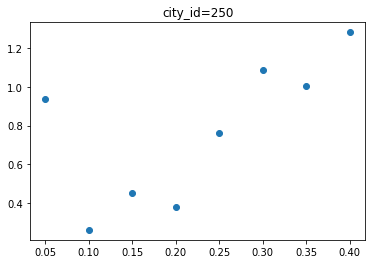

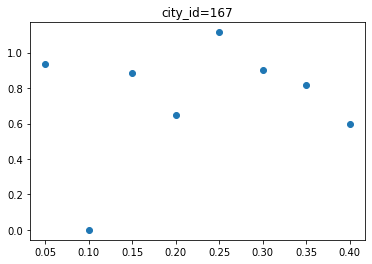

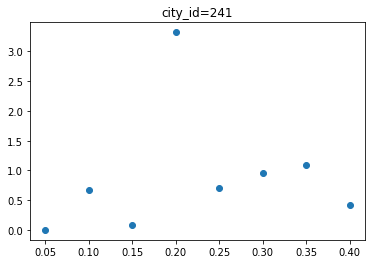

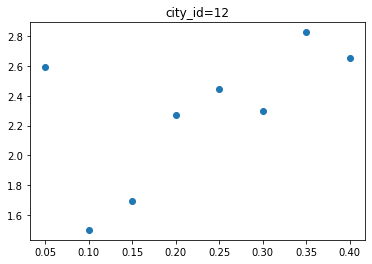

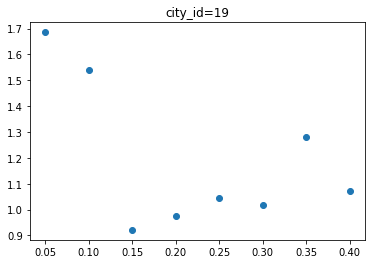

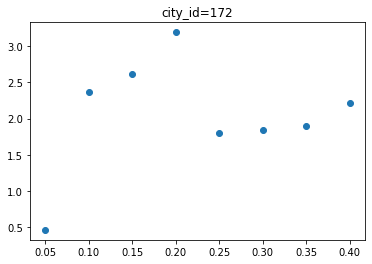

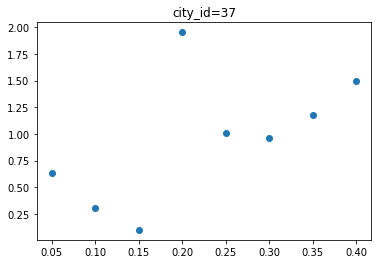

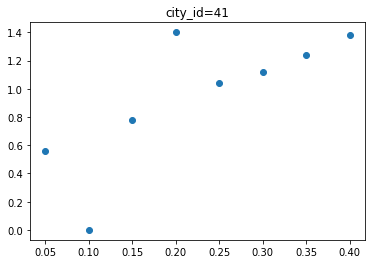

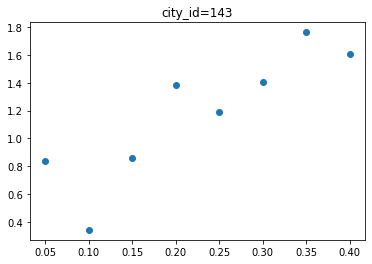

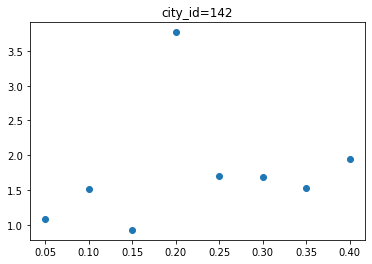

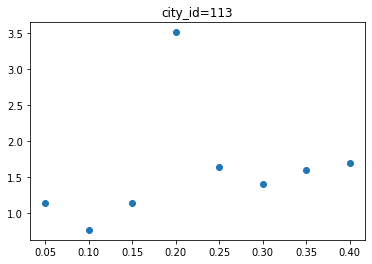

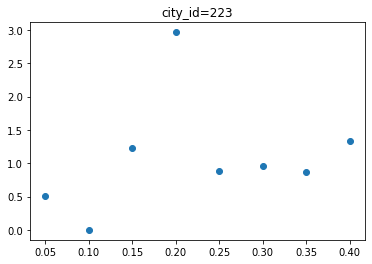

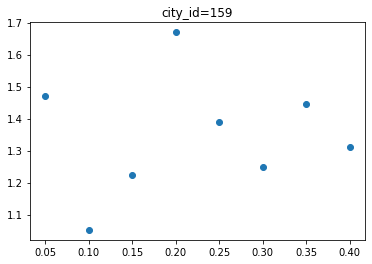

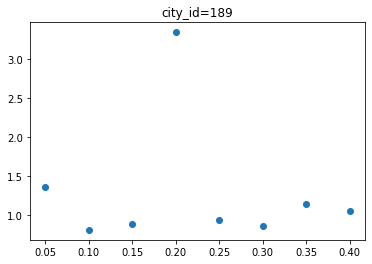

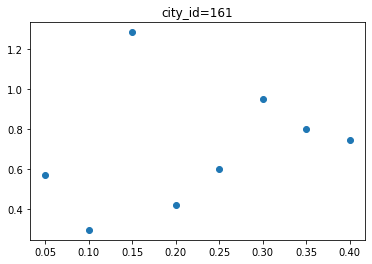

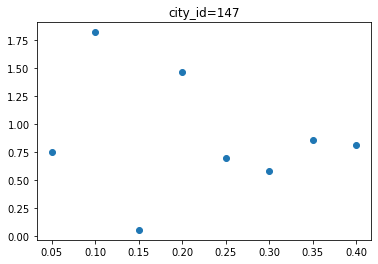

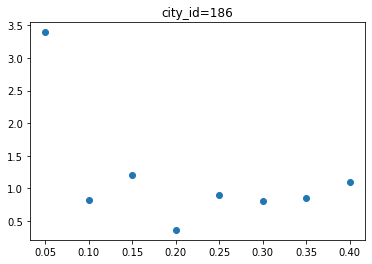

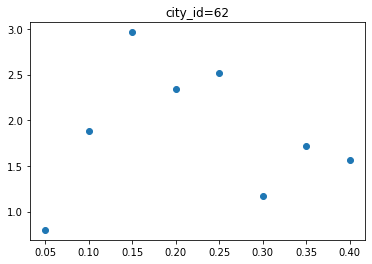

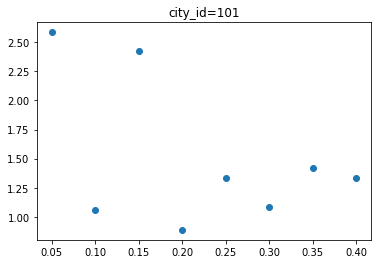

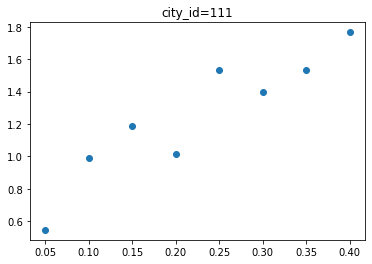

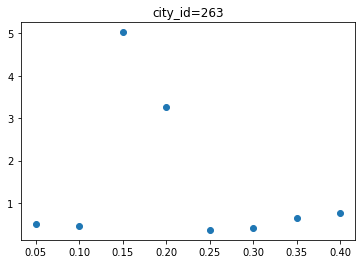

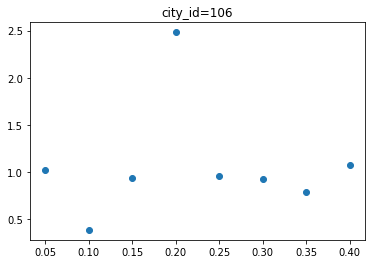

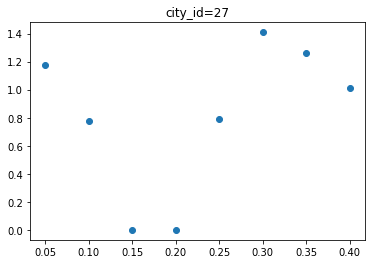

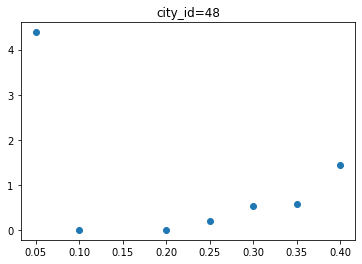

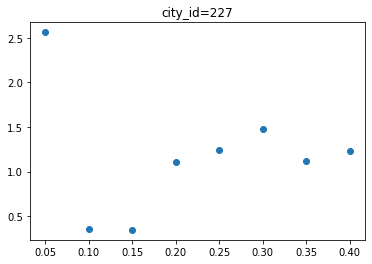

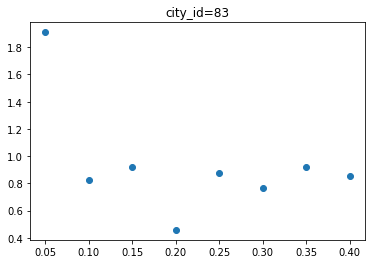

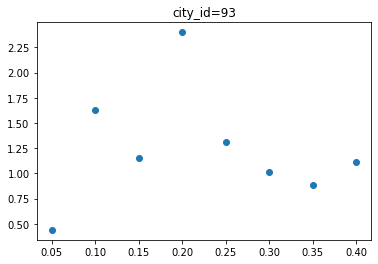

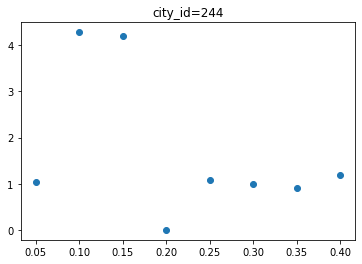

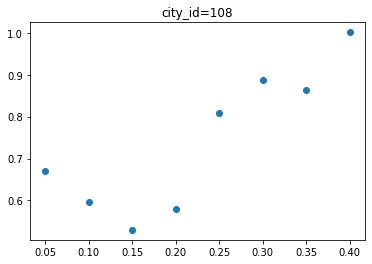

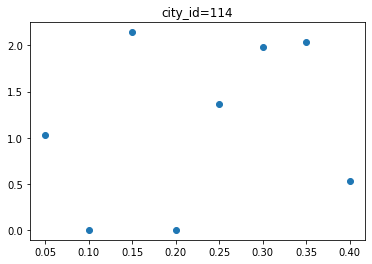

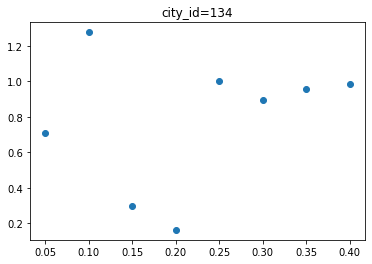

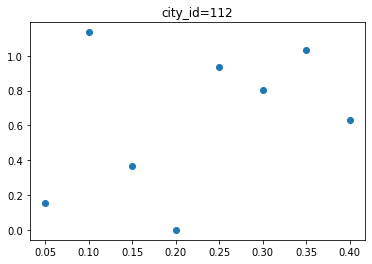

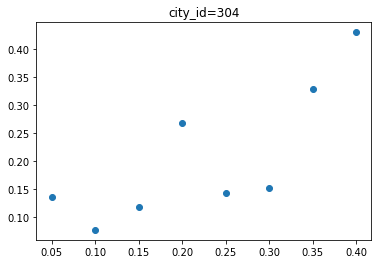

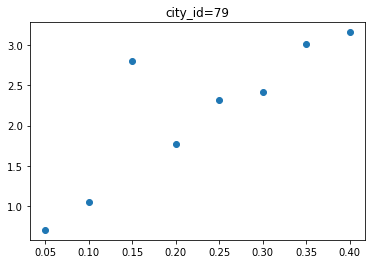

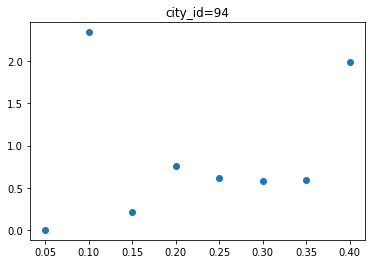

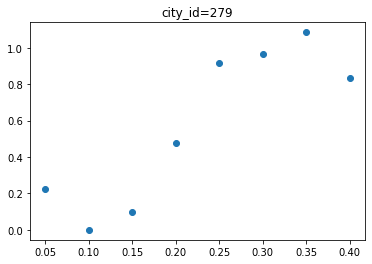

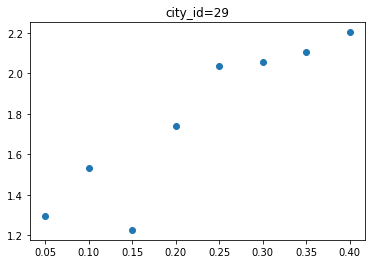

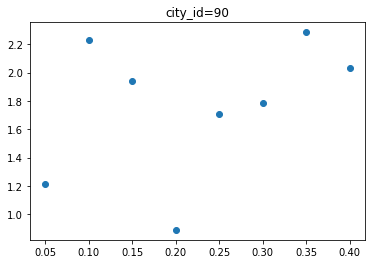

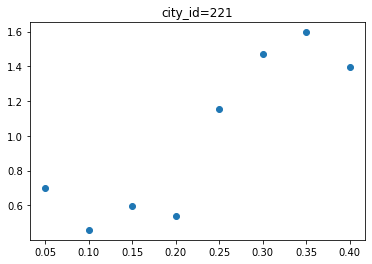

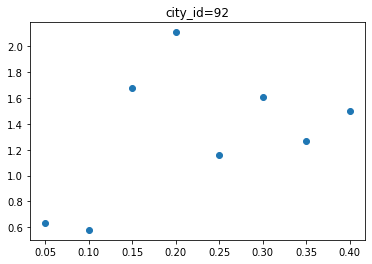

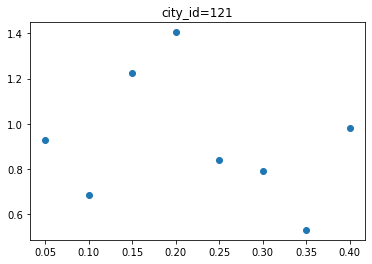

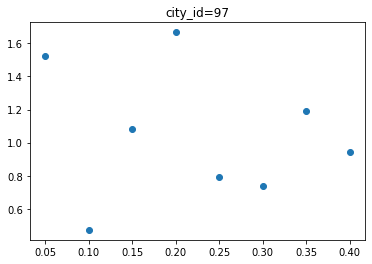

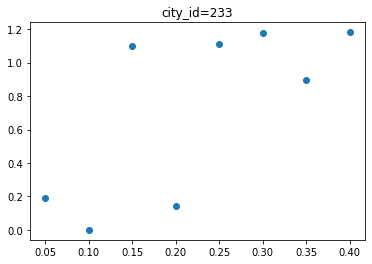

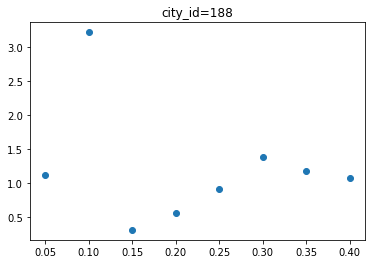

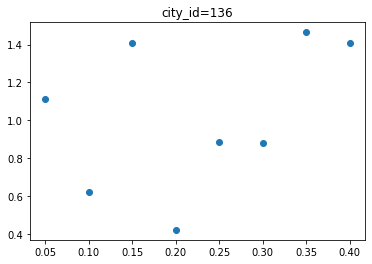

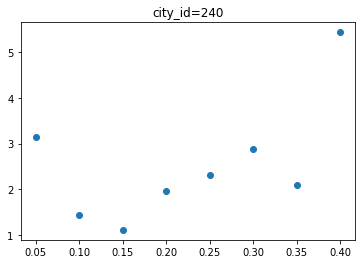

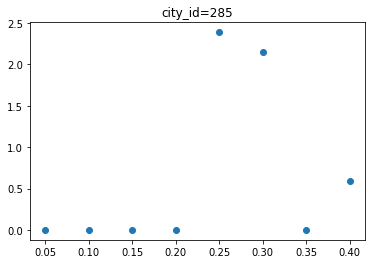

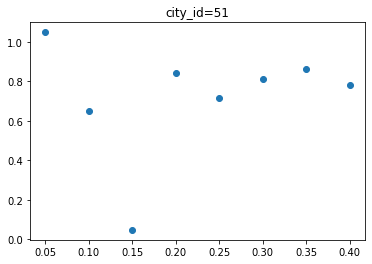

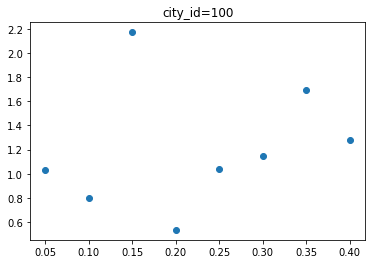

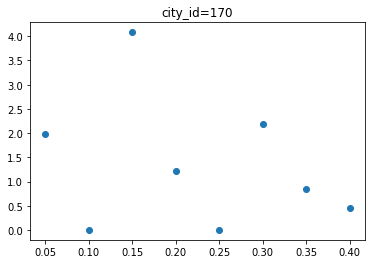

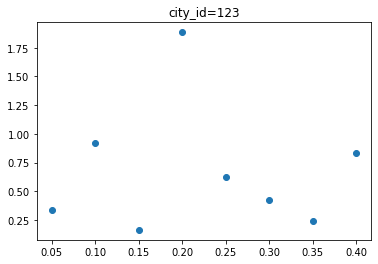

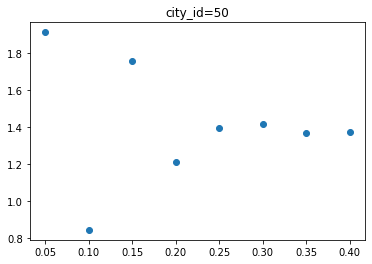

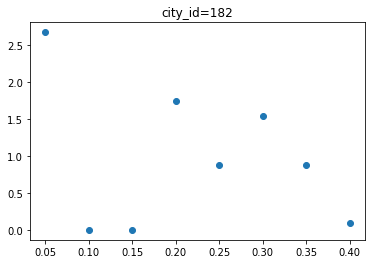

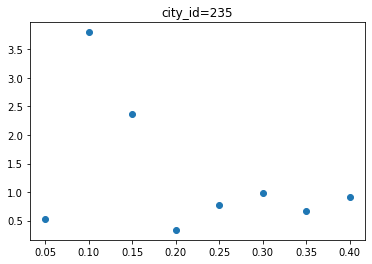

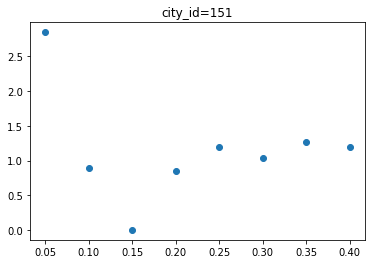

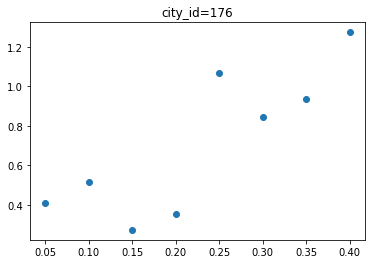

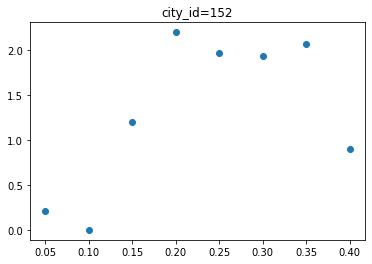

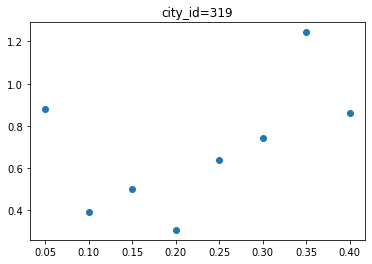

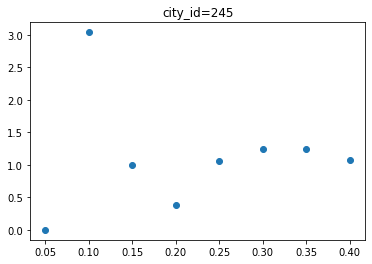

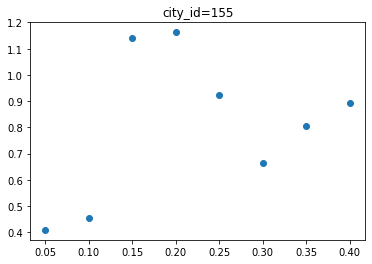

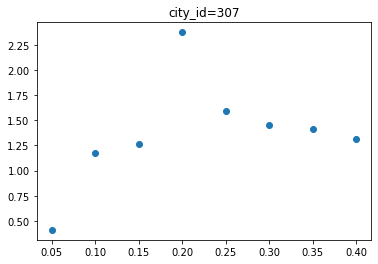

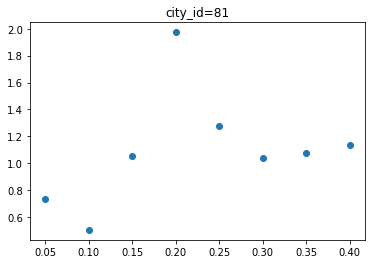

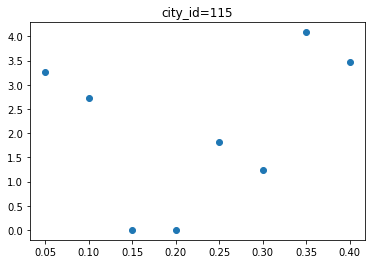

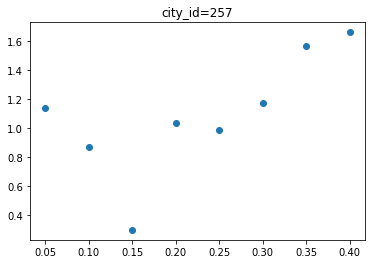

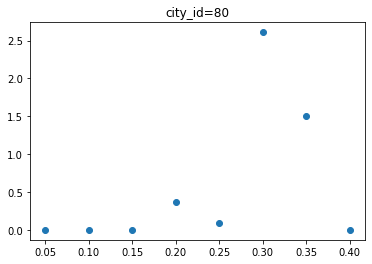

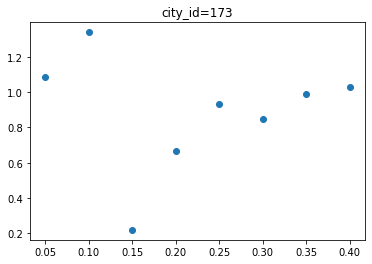

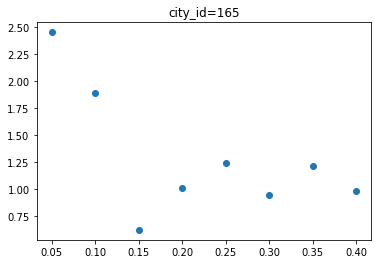

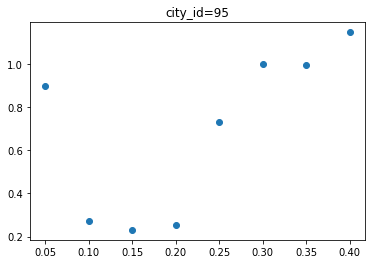

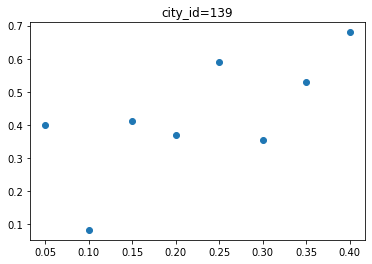

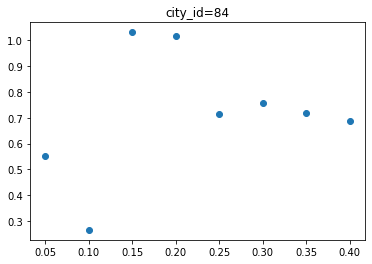

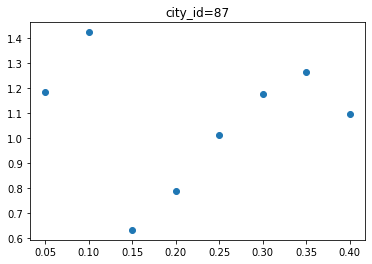

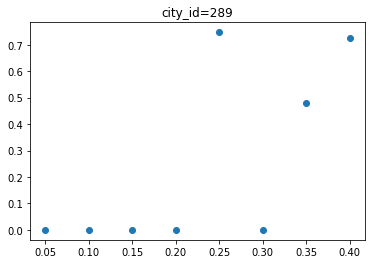

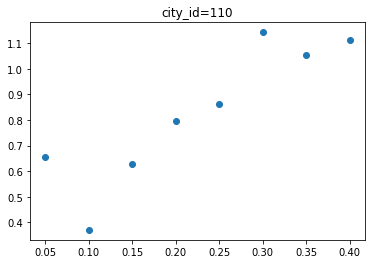

In [26]:
import matplotlib.pyplot as plt

for i, city in enumerate(df['city_id'].drop_duplicates()):
    plt.figure(num=i)
    plt.scatter(1 - df[df['city_id'] == city]['one_discount'], df[df['city_id'] == city]['pp_gmv'])
    plt.title('city_id=%d' % city)
    plt.show()

In [27]:
df = hc.sql('''
select
    city_id,
    case
        when two_discount >= 0.6
        and two_discount < 0.65 then 0.60
        when two_discount >= 0.65
        and two_discount < 0.70 then 0.65
        when two_discount >= 0.70
        and two_discount < 0.75 then 0.70
        when two_discount >= 0.75
        and two_discount < 0.80 then 0.75
        when two_discount >= 0.80
        and two_discount < 0.85 then 0.80
        when two_discount >= 0.85
        and two_discount < 0.90 then 0.85
        when two_discount >= 0.90
        and two_discount < 0.95 then 0.90
        when two_discount >= 0.95
        and two_discount < 1.00 then 0.95
    end as two_discount,
    count(passenger_id) as psg_num,
    sum(subsidy_hufan) as subsidy_hufan,
    sum(gmv) as gmv,
    sum(subsidy_hufan) / sum(gmv) as hufan_rate,
    sum(gmv) / count(passenger_id) as pp_gmv,
    dt
from
    smt_stg.budget_allocation_tequ_explore_202304
where
    product_line = '市内拼车'
group by
    city_id,
    case
        when two_discount >= 0.6
        and two_discount < 0.65 then 0.60
        when two_discount >= 0.65
        and two_discount < 0.70 then 0.65
        when two_discount >= 0.70
        and two_discount < 0.75 then 0.70
        when two_discount >= 0.75
        and two_discount < 0.80 then 0.75
        when two_discount >= 0.80
        and two_discount < 0.85 then 0.80
        when two_discount >= 0.85
        and two_discount < 0.90 then 0.85
        when two_discount >= 0.90
        and two_discount < 0.95 then 0.90
        when two_discount >= 0.95
        and two_discount < 1.00 then 0.95
    end,
    dt
''').toPandas()
df

,city_id,two_discount,psg_num,subsidy_hufan,gmv,hufan_rate,pp_gmv,dt
0,250,0.75,2057,0.0,2271.18,0.0,1.104123,2023-04-19
1,167,0.80,300,0.0,294.04,0.0,0.980133,2023-04-19
2,241,0.85,3272,0.0,2718.44,0.0,0.830819,2023-04-19
3,19,0.75,16125,0.0,16507.45,0.0,1.023718,2023-04-19
4,12,0.90,2452,0.0,3992.67,0.0,1.628332,2023-04-19
5,41,0.95,295,0.0,165.30,0.0,0.560339,2023-04-19
6,142,0.80,5661,0.0,9491.24,0.0,1.676601,2023-04-19
7,113,0.80,2729,0.0,5386.45,0.0,1.973782,2023-04-19
8,223,0.85,1823,0.0,1749.37,0.0,0.959611,2023-04-19
9,159,0.95,839,0.0,1234.79,0.0,1.471740,2023-04-19


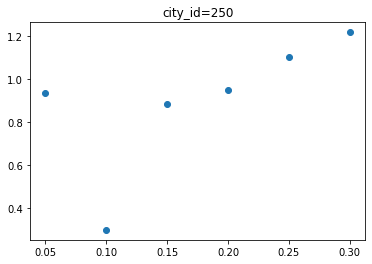

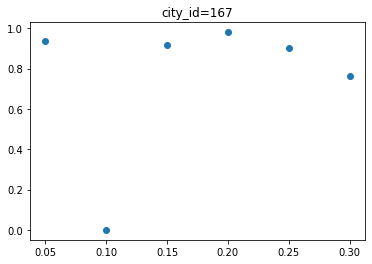

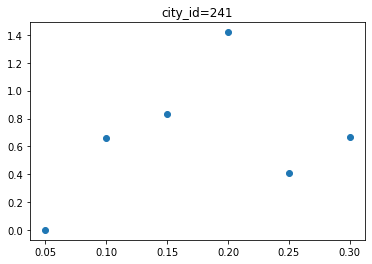

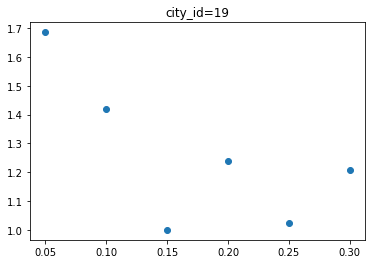

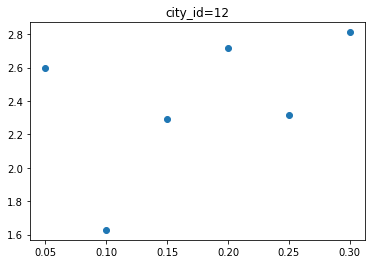

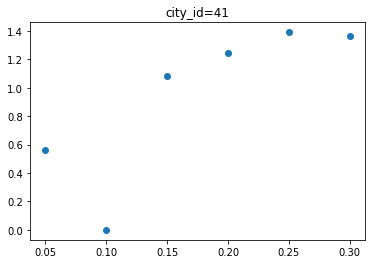

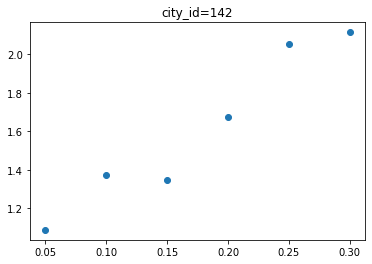

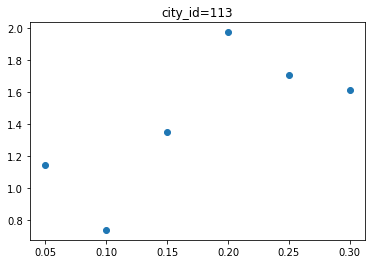

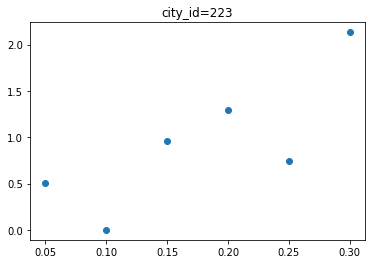

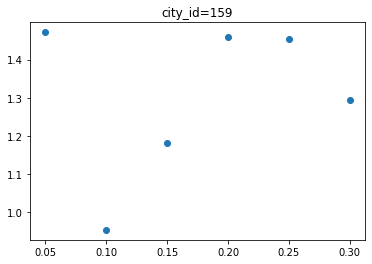

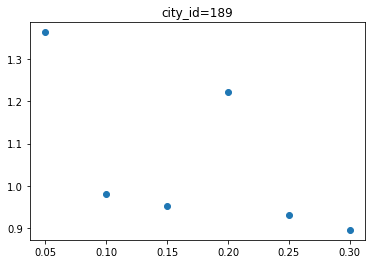

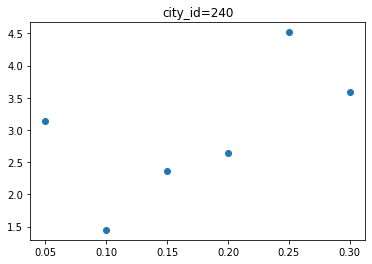

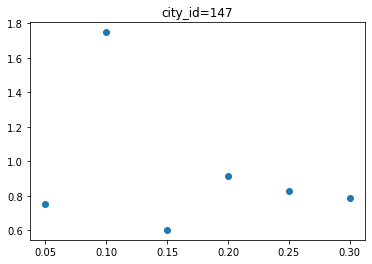

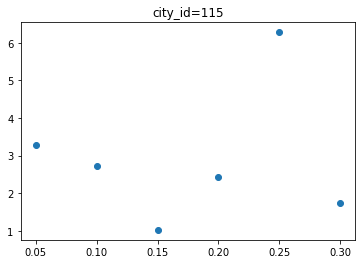

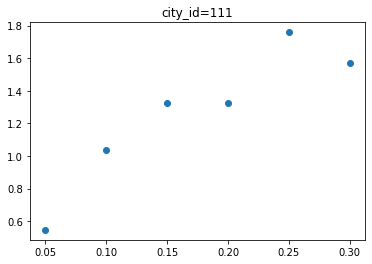

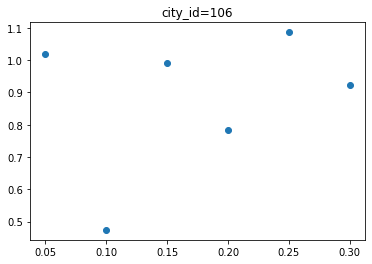

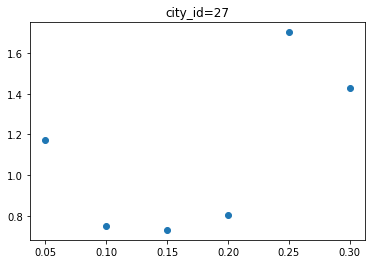

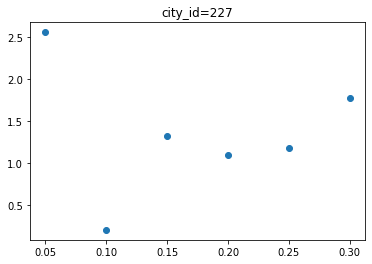

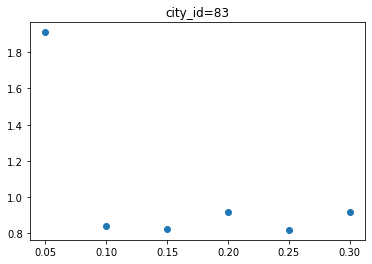

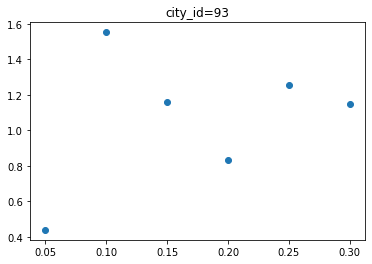

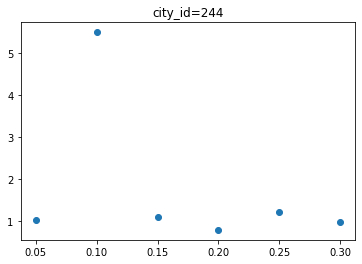

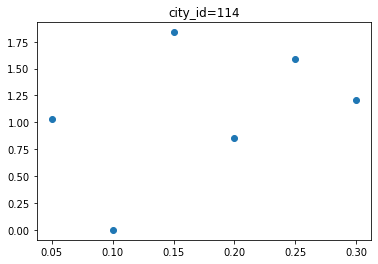

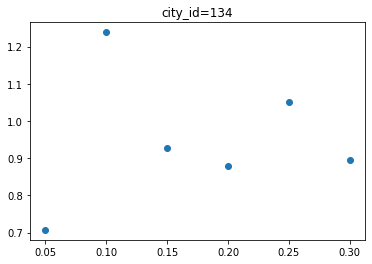

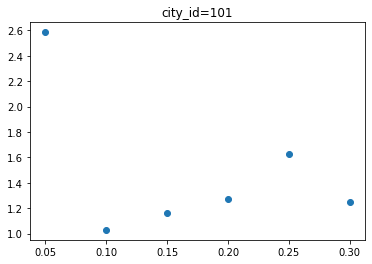

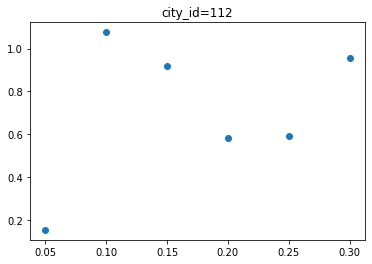

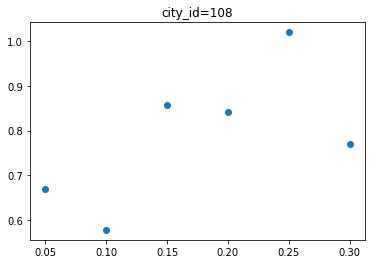

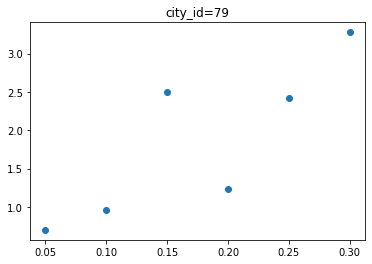

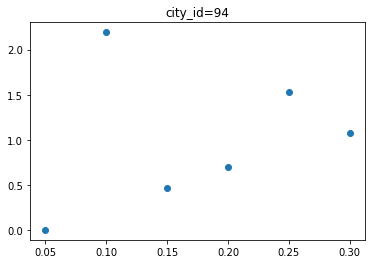

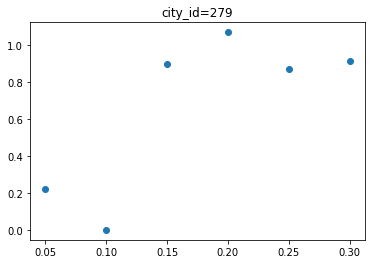

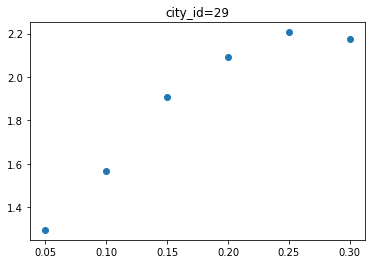

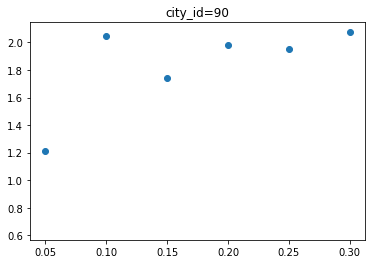

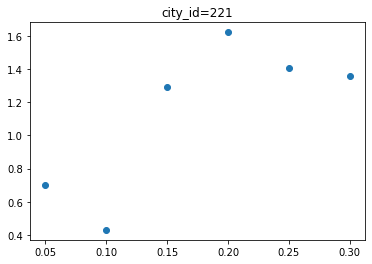

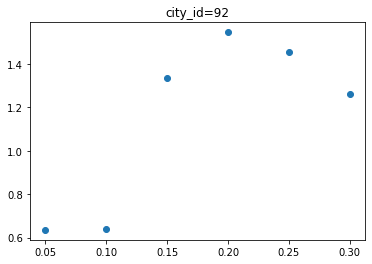

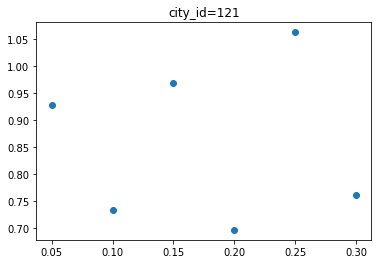

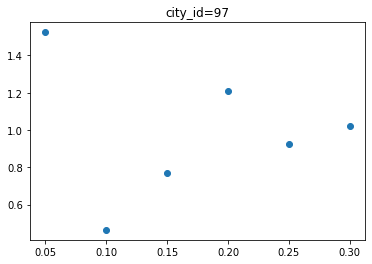

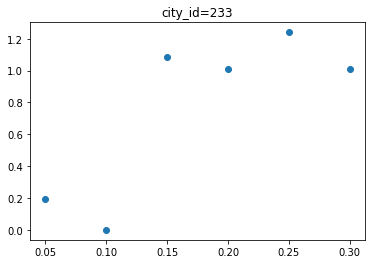

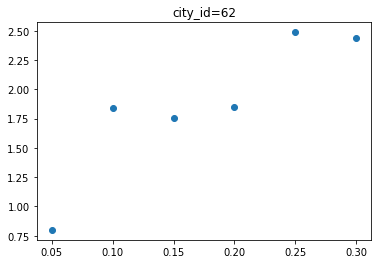

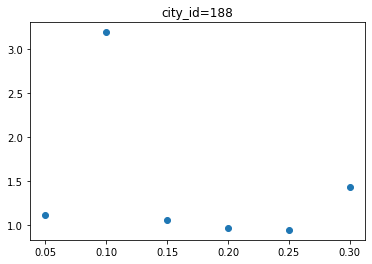

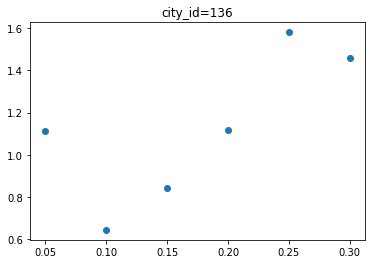

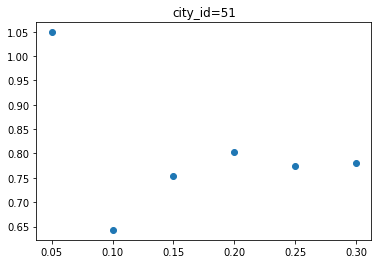

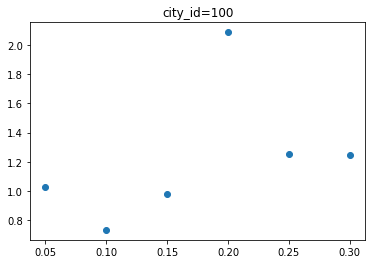

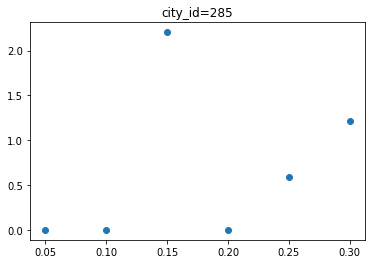

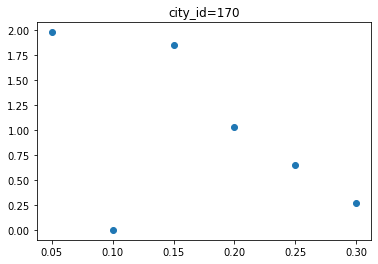

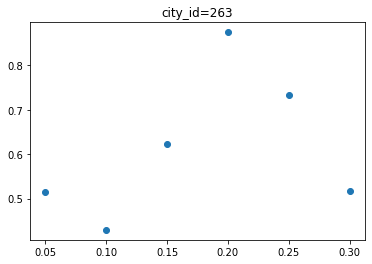

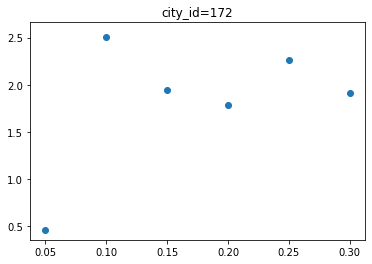

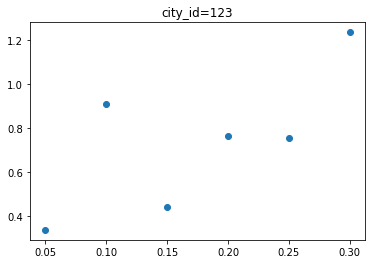

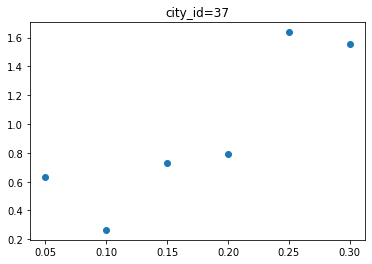

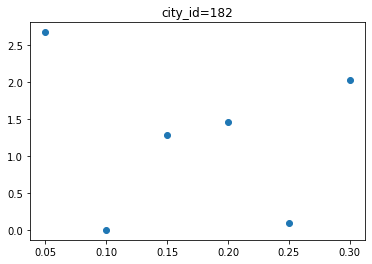

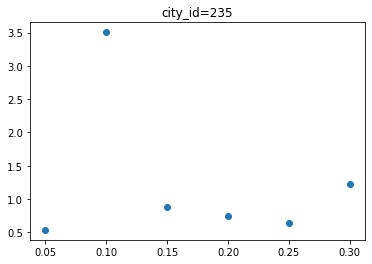

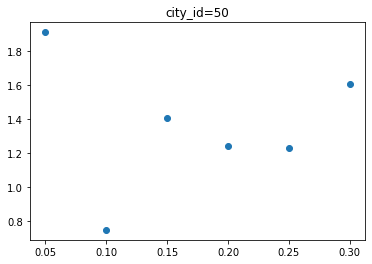

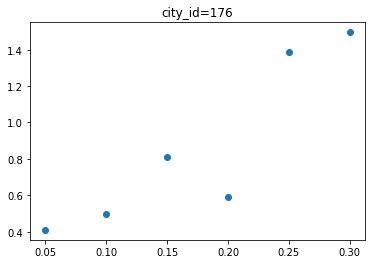

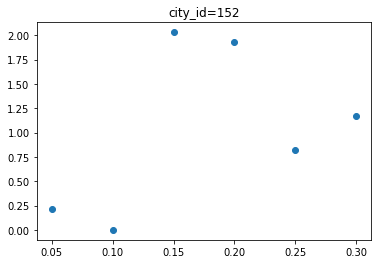

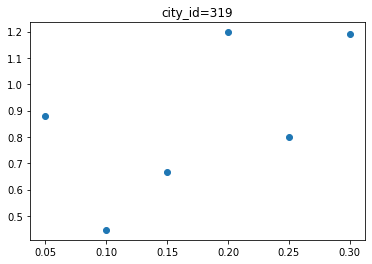

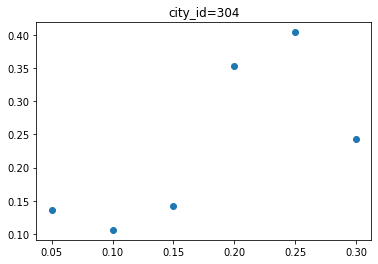

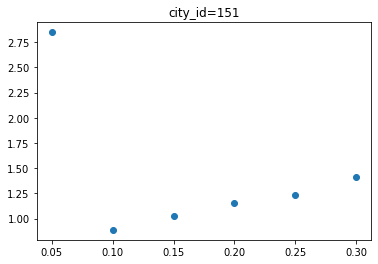

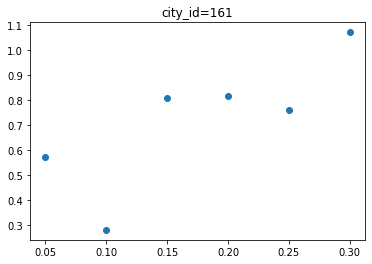

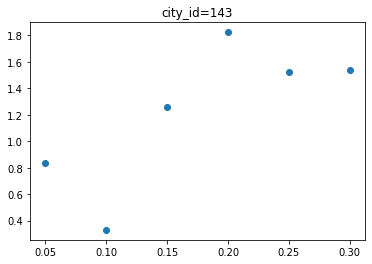

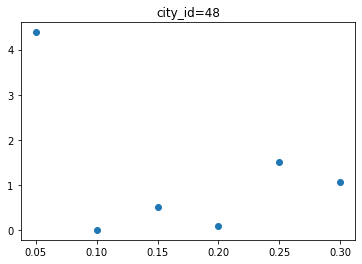

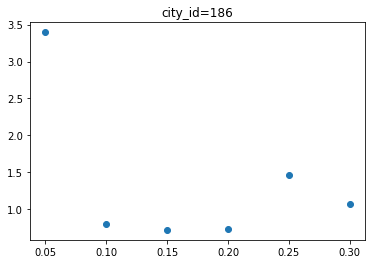

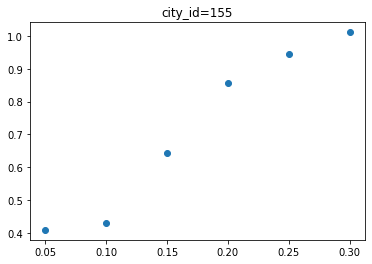

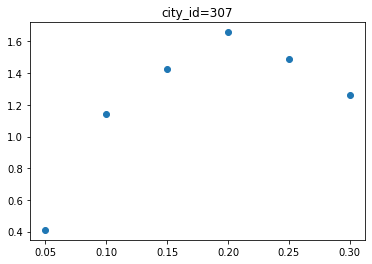

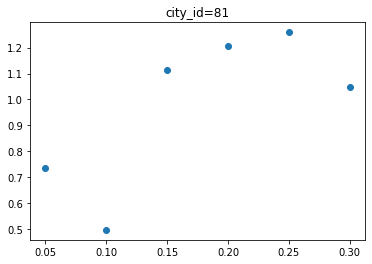

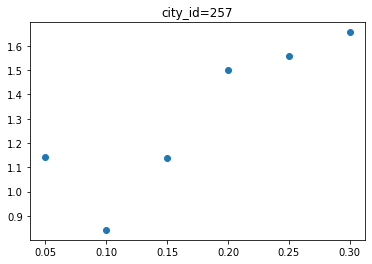

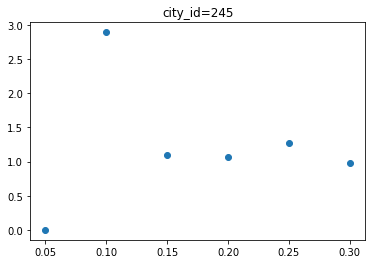

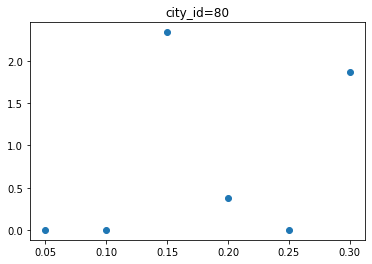

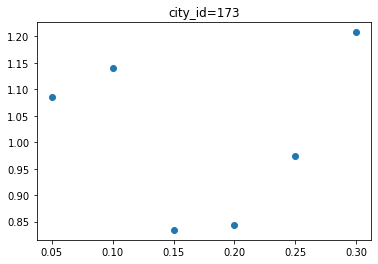

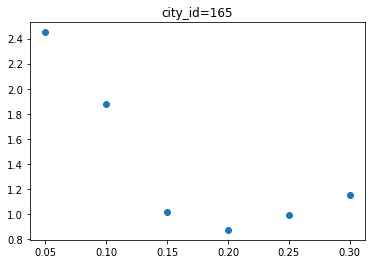

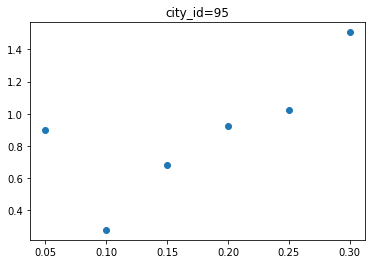

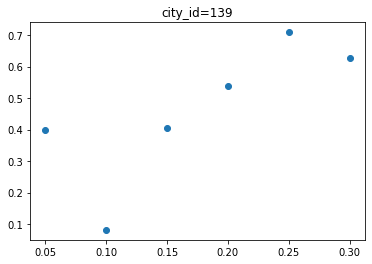

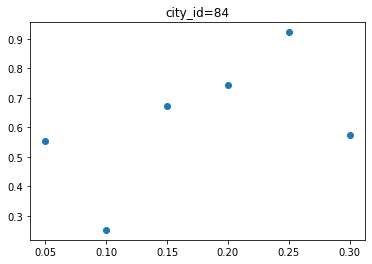

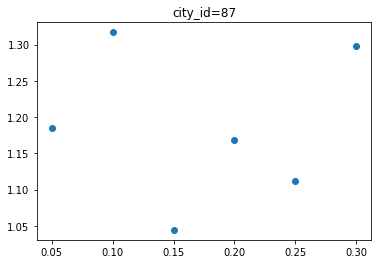

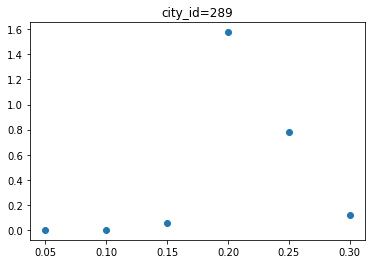

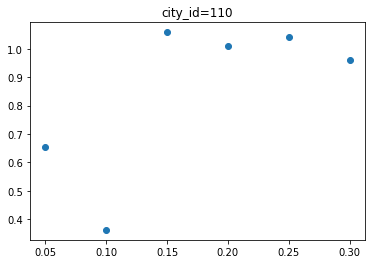

In [28]:
import matplotlib.pyplot as plt

for i, city in enumerate(df['city_id'].drop_duplicates()):
    plt.figure(num=i)
    plt.scatter(1 - df[df['city_id'] == city]['two_discount'], df[df['city_id'] == city]['pp_gmv'])
    plt.title('city_id=%d' % city)
    plt.show()

In [31]:
df = hc.sql('''
select
    city_id,
    case
        when fail_discount >= 0.6
        and fail_discount < 0.65 then 0.60
        when fail_discount >= 0.65
        and fail_discount < 0.70 then 0.65
        when fail_discount >= 0.70
        and fail_discount < 0.75 then 0.70
        when fail_discount >= 0.75
        and fail_discount < 0.80 then 0.75
        when fail_discount >= 0.80
        and fail_discount < 0.85 then 0.80
        when fail_discount >= 0.85
        and fail_discount < 0.90 then 0.85
        when fail_discount >= 0.90
        and fail_discount < 0.95 then 0.90
        when fail_discount >= 0.95
        and fail_discount < 1.00 then 0.95
    end as fail_discount,
    count(passenger_id) as psg_num,
    sum(subsidy_hufan) as subsidy_hufan,
    sum(gmv) as gmv,
    sum(subsidy_hufan) / sum(gmv) as hufan_rate,
    sum(gmv) / count(passenger_id) as pp_gmv,
    dt
from
    smt_stg.budget_allocation_tequ_explore_202304
where
    product_line = '市内拼车'
group by
    city_id,
    case
        when fail_discount >= 0.6
        and fail_discount < 0.65 then 0.60
        when fail_discount >= 0.65
        and fail_discount < 0.70 then 0.65
        when fail_discount >= 0.70
        and fail_discount < 0.75 then 0.70
        when fail_discount >= 0.75
        and fail_discount < 0.80 then 0.75
        when fail_discount >= 0.80
        and fail_discount < 0.85 then 0.80
        when fail_discount >= 0.85
        and fail_discount < 0.90 then 0.85
        when fail_discount >= 0.90
        and fail_discount < 0.95 then 0.90
        when fail_discount >= 0.95
        and fail_discount < 1.00 then 0.95
    end,
    dt
''').toPandas()
df

,city_id,fail_discount,psg_num,subsidy_hufan,gmv,hufan_rate,pp_gmv,dt
0,173,0.92,18,0.0,9.96,0.0,0.553333,2023-04-19
1,95,0.94,46,0.0,0.00,NaN,0.000000,2023-04-19
2,182,0.91,116,0.0,189.56,0.0,1.634138,2023-04-19
3,27,0.95,443,0.0,311.35,0.0,0.702822,2023-04-19
4,121,0.96,31,0.0,106.61,0.0,3.439032,2023-04-19
...,...,...,...,...,...,...,...,...
1148,115,1.00,1,0.0,0.00,NaN,0.000000,2023-04-19
1149,37,0.86,5,0.0,0.00,NaN,0.000000,2023-04-19
1150,241,0.90,3,0.0,0.00,NaN,0.000000,2023-04-19
1151,50,0.98,3,0.0,47.82,0.0,15.940000,2023-04-19


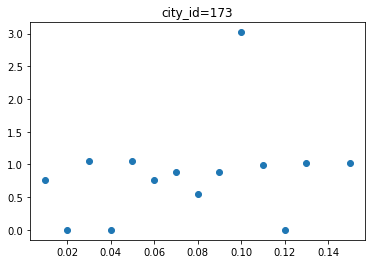

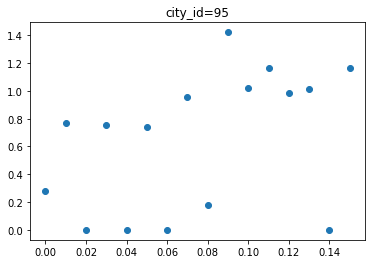

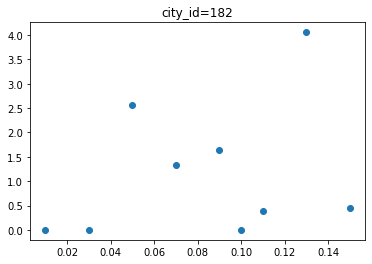

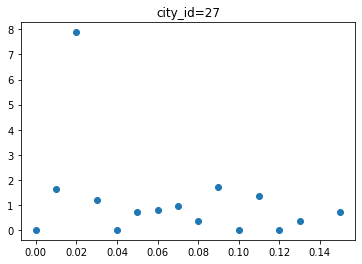

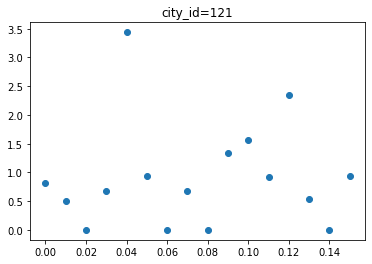

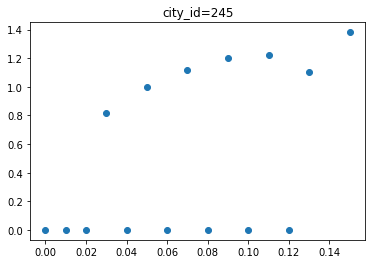

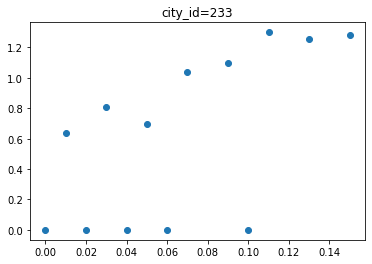

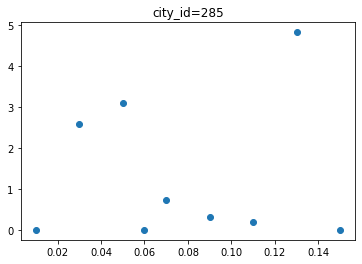

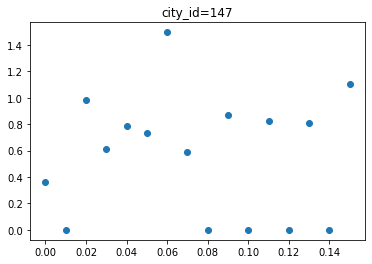

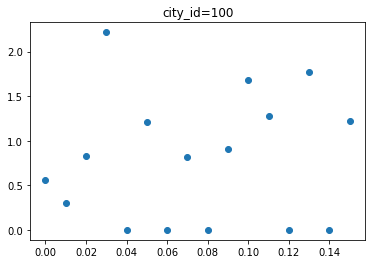

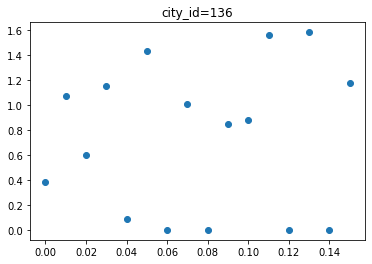

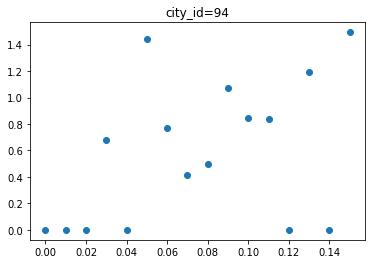

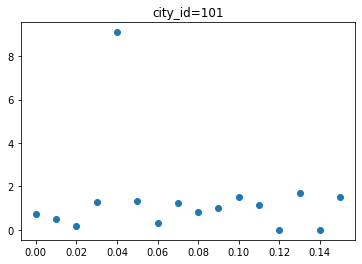

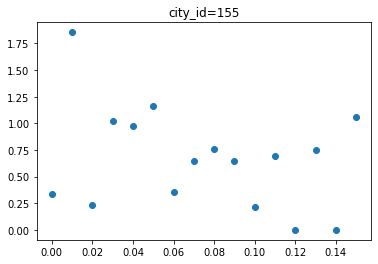

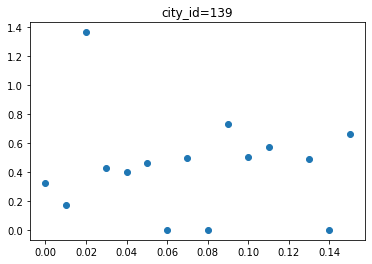

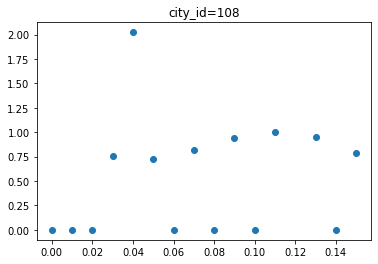

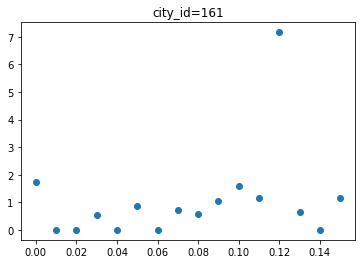

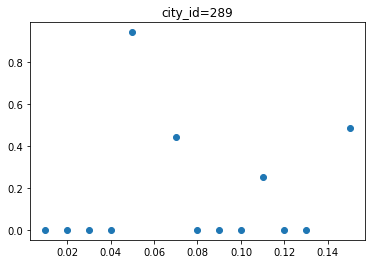

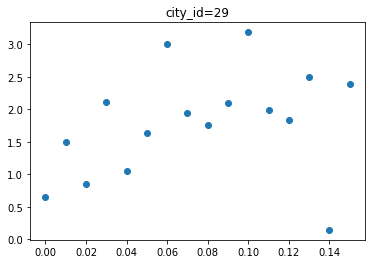

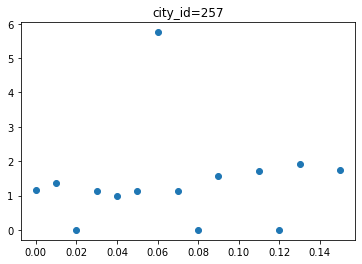

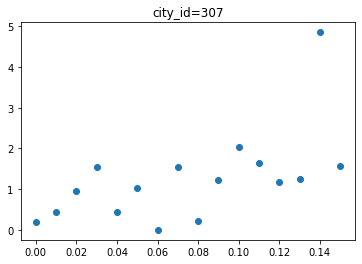

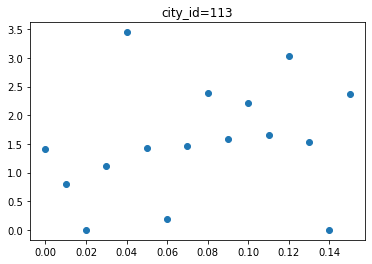

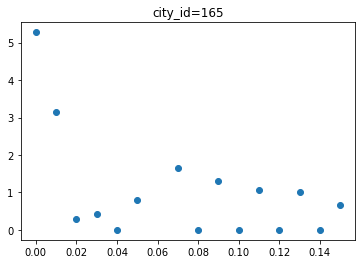

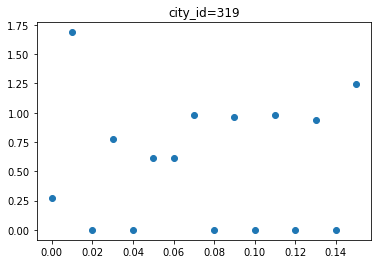

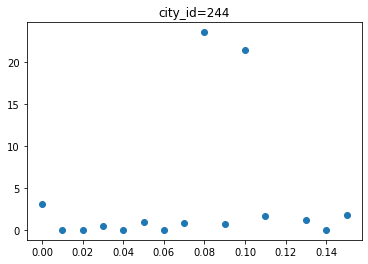

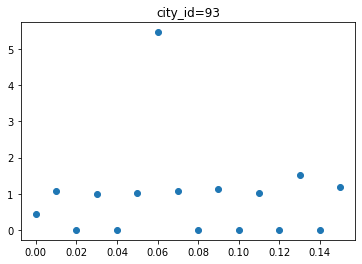

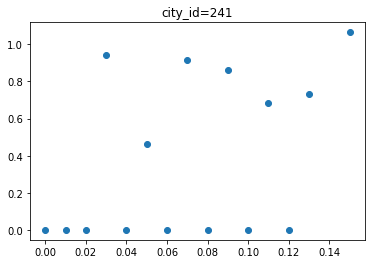

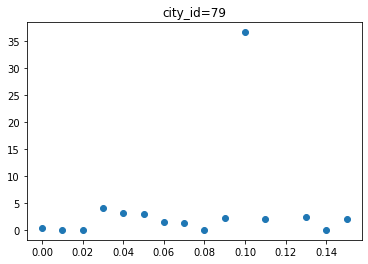

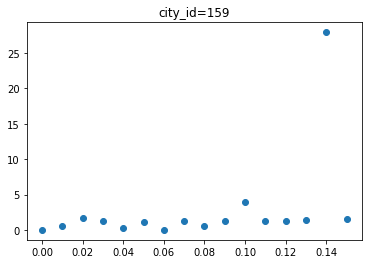

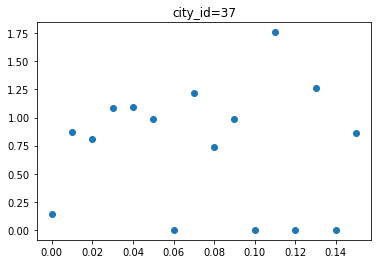

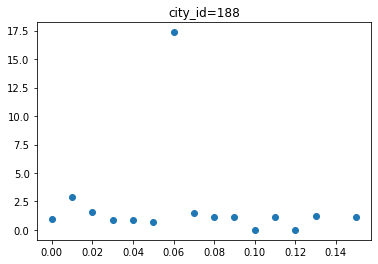

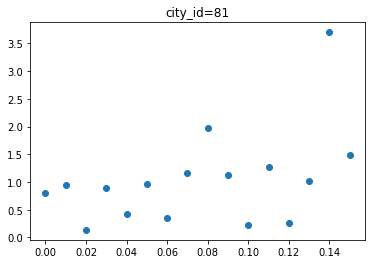

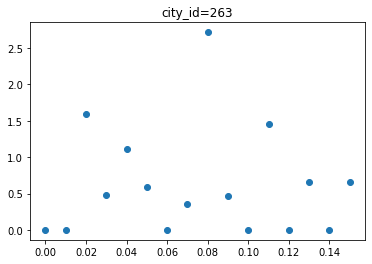

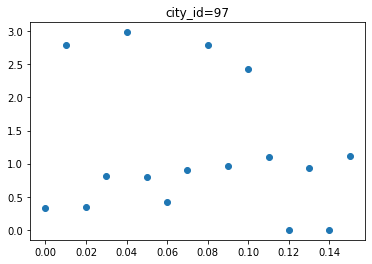

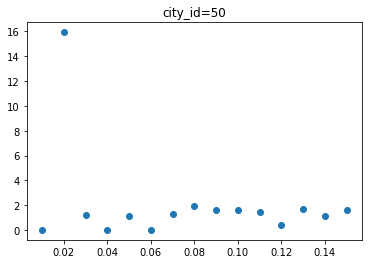

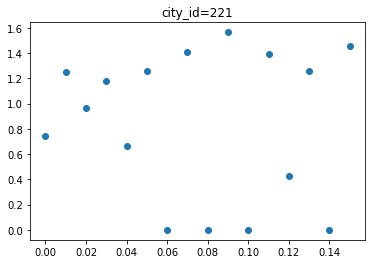

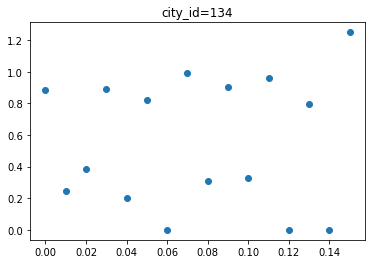

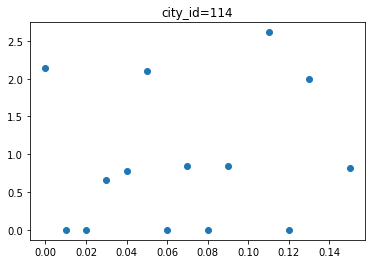

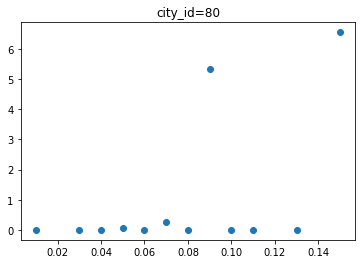

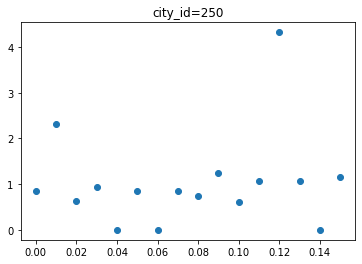

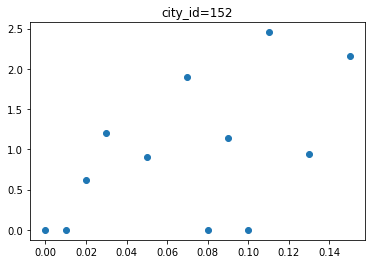

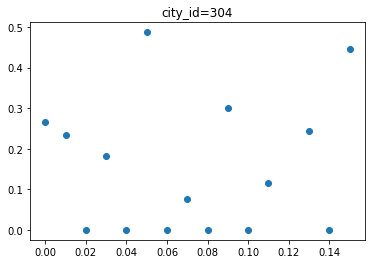

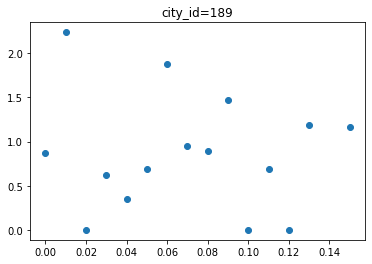

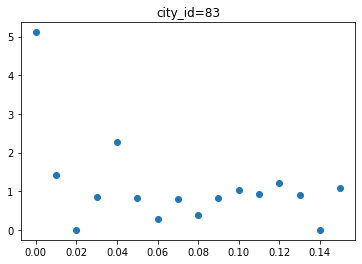

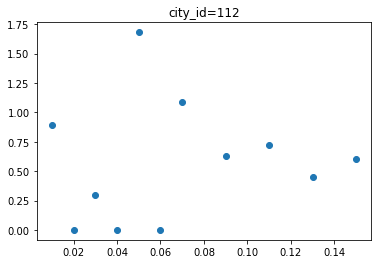

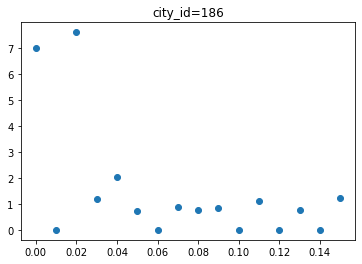

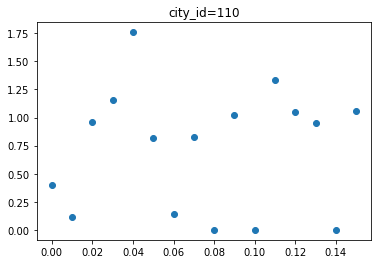

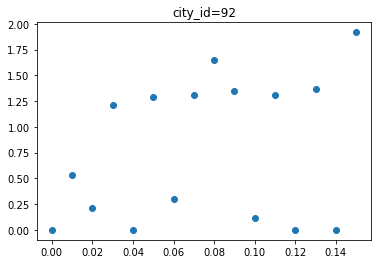

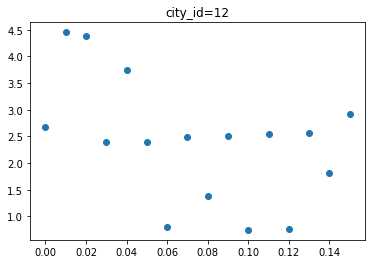

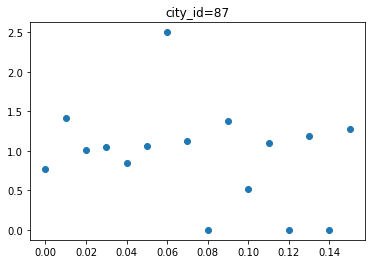

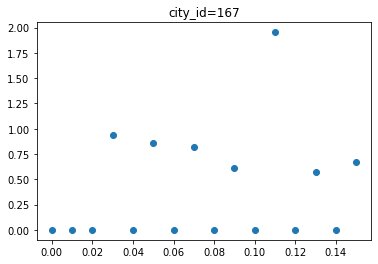

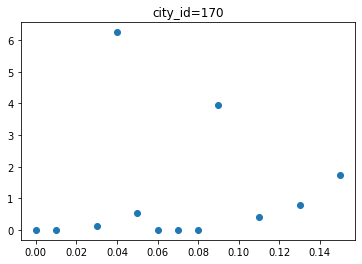

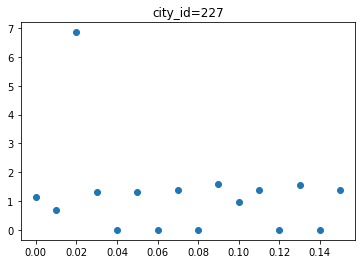

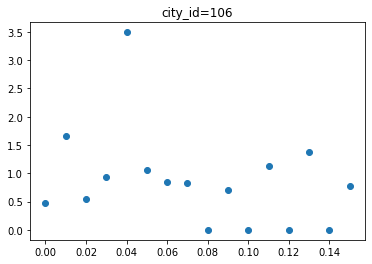

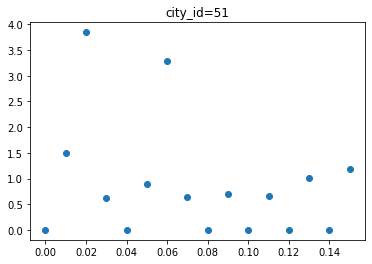

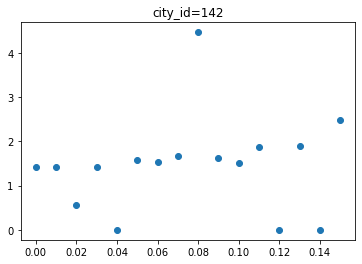

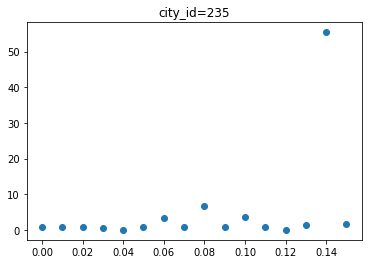

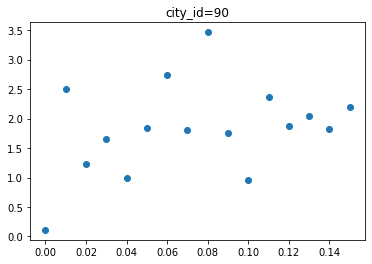

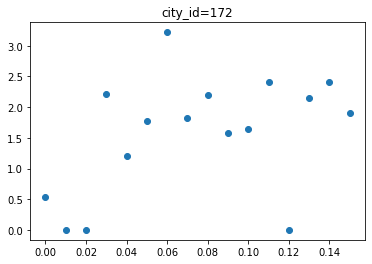

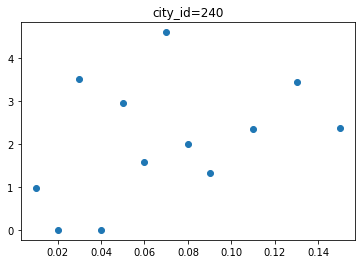

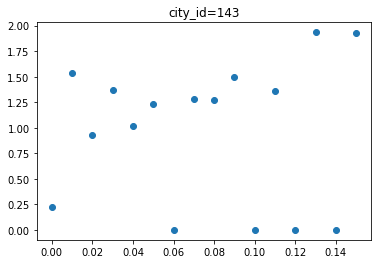

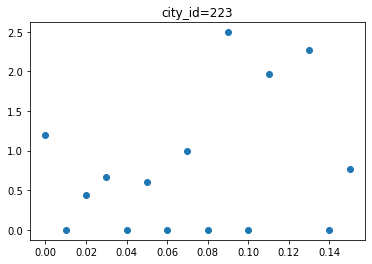

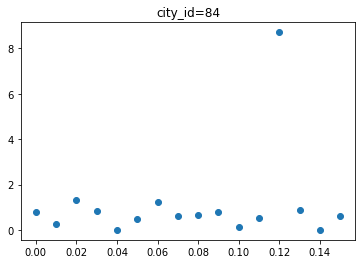

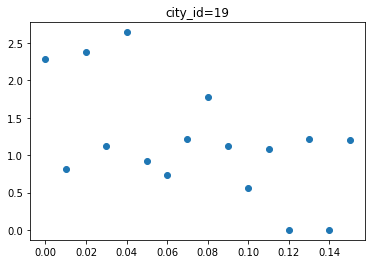

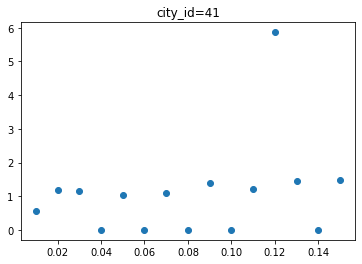

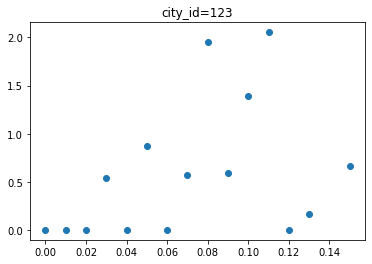

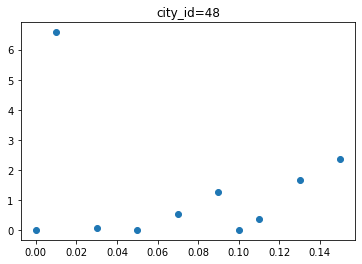

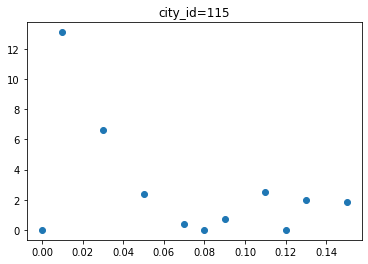

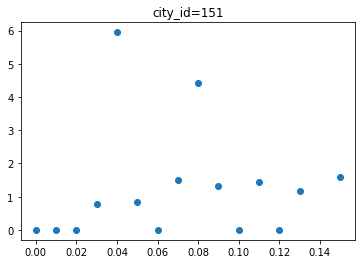

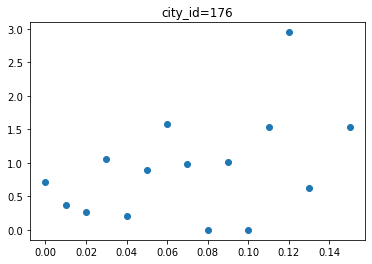

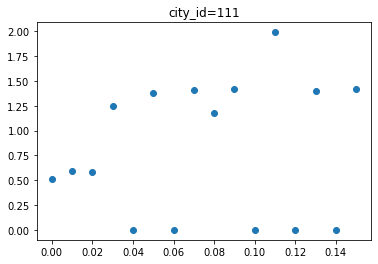

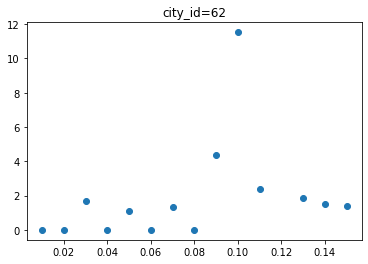

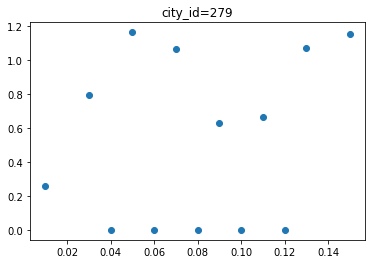

In [32]:
import matplotlib.pyplot as plt

for i, city in enumerate(df['city_id'].drop_duplicates()):
    plt.figure(num=i)
    plt.scatter(1 - df[df['city_id'] == city]['fail_discount'], df[df['city_id'] == city]['pp_gmv'])
    plt.title('city_id=%d' % city)
    plt.show()